In [116]:
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,auc,roc_auc_score,recall_score,classification_report,precision_recall_curve, roc_curve
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [117]:
data= pd.read_csv('C:/Users/Kshitij/Desktop/Study/Kaggle/Credit Card/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Preprocessing and EDA :

Lets start by finding out if there is any correlation in the variables in the dataset

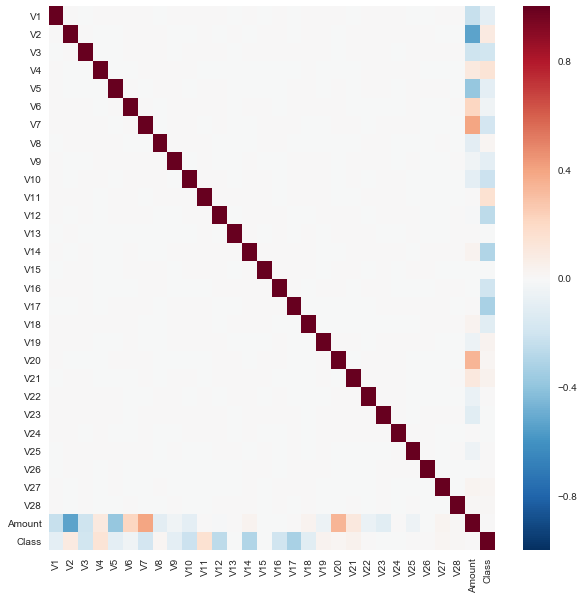

In [118]:
plt.rcParams['figure.figsize']=(10,10)
sns.heatmap(train.corr())
sns.plt.show()

Looking above it is safe to say that the data is uncorrelated and hence we can moveforward with our analysis. Lets check for missing values and do some Exploratory Data Analysis before we move forward.

Looking for missing values in the Data - 

In [119]:
data.isnull().any().sum()

0

No missing values found!
Lets see the **'Class'** in the data

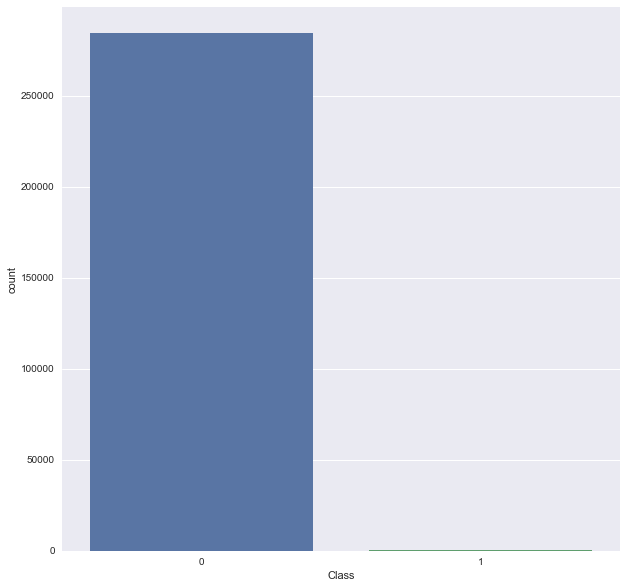

Percent of fraud transaction:  0.1727485630620034 %


In [120]:
sns.countplot(data['Class'])
sns.plt.show()
print('Percent of fraud transaction: ',len(data[data['Class']==1])/len(data['Class'])*100,"%")

Seeing the above plot we can say that the data is Highly imbalanced meaning that the ratio of normal transactions to fraud transactions is is very high or that fraud transactions are very very few. This will make our data highly [imbalanced](http://www.chioka.in/class-imbalance-problem/).

Lets take a look at how **Amount** looks like for normal and then for fraud transaction-

C:\Users\Kshitij\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


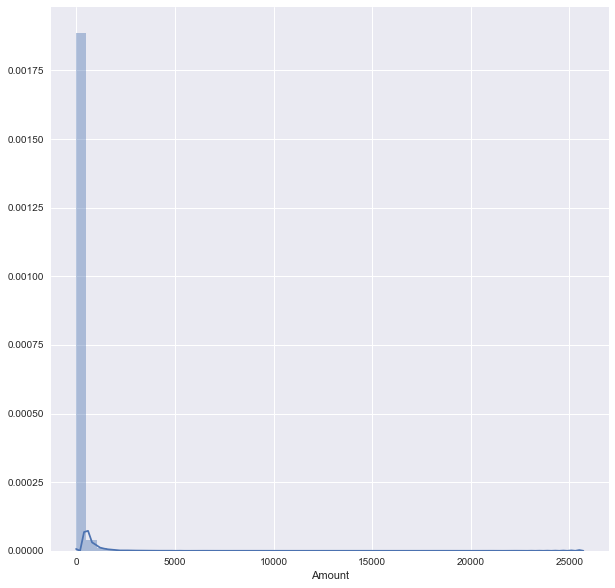

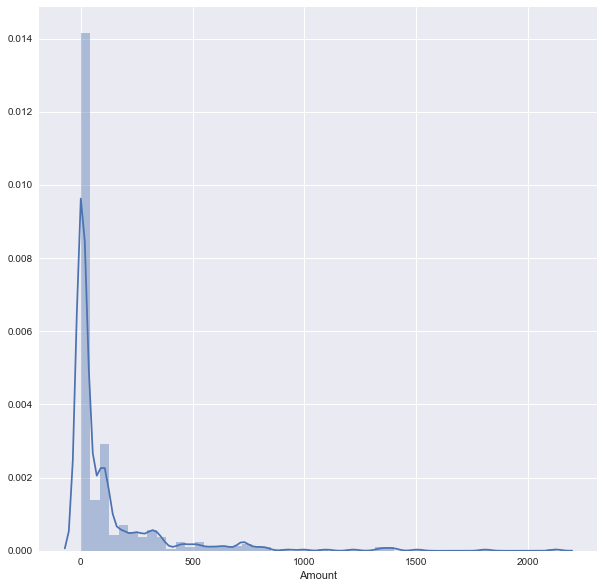

In [121]:
sns.distplot(data.Amount)
sns.plt.show()
sns.distplot(data[data.Class==1].Amount)
sns.plt.show()


We can see from above that the maximum fraudulent transactions happen for small amount and next to negligiable for higher transaction. **But is the mean of transaction for fradulent transaction amount higher or lower than the mean of normal transaction?**
For this lets perform a Hypothesis test and get the result through statistics.

        H0: Mean of Fradulent transaction = Mean of Normal Transaction
        H1: Mean of Fradulent transaction != Mean of Normal Transaction
        
Lets calculate 'Z', 'μ' and S.E -

In [122]:
population = data[data.Class == 0].Amount
sample = data[data.Class == 1].Amount
sampleMean = sample.mean()
populationStd = population.std()
populationMean = population.mean()
z_score = (sampleMean - populationMean) / (populationStd / sample.size ** 0.5)
z_score

3.008289898215099

Since Z score is more than **2.576** we can say we **reject** the Null Hypothesis and hence the mean of amount of fradulent transaction is more than the normal transaction. This is a very good insight as this can help us see the characterstics of a fradulent transaction. 

Lets prepare to run a Logistic Regression on the data. We will start by dropping unneccesary columns and splitting it into Train and Test.

Also since the data is imbalanced, we will undersample the data so as to process it and use it to fit a model. 

In [123]:
train= data.drop(['Time'], axis=1)

X= train.ix[:, train.columns != 'Class']
y= train.ix[:, train.columns == 'Class'] 

Lets assign random variables to the undersample class and then break the data set into Test and Train and Test Undersample and Train Undersample.
#### Lets 1st try to run a model without tackling the problem of imbalanced class and see what precision we get.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

Defining a function to plot the confusion matrix. [Source](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [125]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=15)
    plt.yticks(tick_marks, classes, rotation=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    
        #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix undersampled


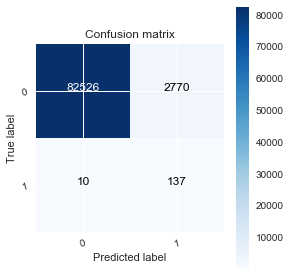

cr:              precision    recall  f1-score   support

          0       1.00      0.97      0.98     85296
          1       0.05      0.93      0.09       147

avg / total       1.00      0.97      0.98     85443



In [126]:
class_set = [0, 1]
lr = LogisticRegression()
lr.fit(X_train, y_train.values.ravel())
y_pred = lr_und.predict(X_test)
cnf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
np.set_printoptions(precision=2)
print ("Confusion matrix undersampled")
plt.rcParams['figure.figsize']=(4,4)
plot_confusion_matrix(cm=cnf_matrix, classes=class_set)
plt.show()
print('cr:', classification_report(y_test,y_pred))

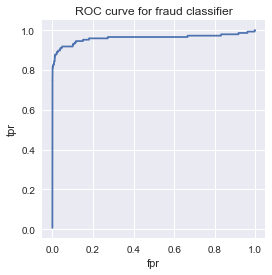

0.96117346300741269

In [127]:
y_predprob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,y_predprob)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve for fraud classifier')
plt.grid(True)
plt.show()
roc_auc_score(y_test, y_predprob)

We can see that the precision we got is somewhat about .05 which is very low, hence this is why we need to undersample the data to deal with Class Imbalance.

#### Using the Undersampled Test and Train data and running the model.

Preparing for Undersampling - 

In [128]:
fraud_count = len(train[train.Class == 1])

fraud_indices = train[train.Class == 1].index
normal_indices = train[train.Class == 0].index

r_normal_indices = np.random.choice(normal_indices, fraud_count, replace = False)

undersample_indices = np.concatenate([fraud_indices,r_normal_indices])
undersample_train = train.iloc[undersample_indices,:]

X_undersample = undersample_train.ix[:, undersample_train.columns != 'Class']
y_undersample = undersample_train.ix[:, undersample_train.columns == 'Class']

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_undersample,y_undersample,test_size = 0.3,random_state = 0)

Confusion matrix undersampled


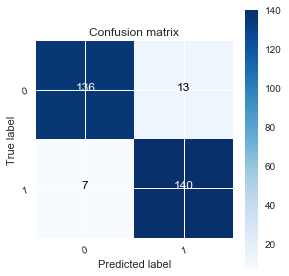

cr:              precision    recall  f1-score   support

          0       0.95      0.91      0.93       149
          1       0.92      0.95      0.93       147

avg / total       0.93      0.93      0.93       296



In [129]:
class_set = [0, 1]
lr_und = LogisticRegression()
lr_und.fit(X_train_u, y_train_u.values.ravel())
y_pred_und = lr_und.predict(X_test_u)
cnf_matrix_und = confusion_matrix(y_true=y_test_u, y_pred=y_pred_u)
np.set_printoptions(precision=2)
print ("Confusion matrix undersampled")
plt.rcParams['figure.figsize']=(4,4)
plot_confusion_matrix(cm=cnf_matrix_und, classes=class_set)
plt.show()
print('cr:', classification_report(y_test_u,y_pred_u))

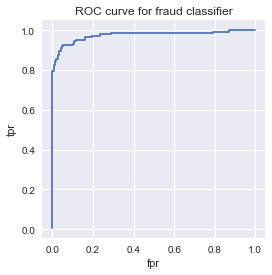

0.97548281057389397

In [130]:
y_predprob_u = logreg.predict_proba(X_test_u)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_u,y_predprob_u)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve for fraud classifier')
plt.grid(True)
plt.show()
roc_auc_score(y_test_u, y_predprob_u)

We can see the difference between unsampled and undersampled data. The precision rises from **0.05 to 0.92** which clearly demonstrates how important it is to undersample the data when there is a class imbalance! We can improve our model even further by using a lot of further more techniques such as using cross validation, threshold calculation etc.